# Re-analysis of *in vitro* CD34+ HPSC *in vitro* differentiation experiments using MEGATRON

**Data from:**
Lareau, C. A., Ludwig, L. S., Muus, C., Gohil, S. H., Zhao, T., Chiang, Z., Pelka, K., Verboon, J. M., Luo, W., Christian, E., Rosebrock, D., Getz, G., Boland, G. M., Chen, F., Buenrostro, J. D., Hacohen, N., Wu, C. J., Aryee, M. J., Regev, A., & Sankaran, V. G. (2021). Massively parallel single-cell mitochondrial DNA genotyping and chromatin profiling. Nature Biotechnology, 39(4), 451–461. https://doi.org/10.1038/s41587-020-0645-6

[Code to generate the paper figures (GitHub) ](https://github.com/caleblareau/mtscATACpaper_reproducibility)

[All data files from the paper (OSF)](https://osf.io/bupge/)

In [1]:
import pandas as pd
import megatron as me
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

from adjustText import adjust_text
from scipy.sparse import csr_matrix, save_npz

In [2]:
clone_pal=[p for i, p in enumerate(sns.color_palette("colorblind")) if i != 1]

sns.set_theme(context="notebook", style="white", palette=clone_pal, rc={"figure.figsize":[5,5], 'image.cmap':'coolwarm'})
me.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              palette=clone_pal,
                              rc={'image.cmap': 'coolwarm'})


In [3]:
%load_ext autoreload

## Preprocessing
Load the data (UMAP coordinates and metadata exported from the original SingleCellExperiment object)

In [4]:
data_df = pd.read_csv("../data/CD34_all.csv", index_col=0)
data_df.set_index("barcode", inplace=True)
data_df.index.rename("", inplace=True)
data_df['clone_id'] = data_df['dataset']+'_'+data_df['cluster'].map(str) 
data_df

,cluster,dataset,X1,X2,clusters,sample,depth,FRIP,mtDNAcoverage,library,GATA1,CEBPA,SPI1,RUNX1,PAX5,KLF1,IRF8,new_name,density,clone_id
,,,,,,,,,,,,,,,,,,,,
CD34_500_Day08-AAACGAAAGACAGCTG-1,0,CD34_500,2.208647,6.137926,mc5,AAACGAAAGACAGCTG-1,37011,0.473535,150.59,CD34_500_Day08,-10.865512,1.242316,8.332681,-1.765986,-0.649625,-3.438681,1.954597,my1,0.003688,CD34_500_0
CD34_500_Day08-AAACGAACATAGATAG-1,0,CD34_500,10.386391,5.496093,mc8,AAACGAACATAGATAG-1,33704,0.526466,55.30,CD34_500_Day08,6.301466,-0.472604,-1.064759,4.054766,0.322210,-0.250997,1.679375,prog,0.004320,CD34_500_0
CD34_500_Day08-AAACGAAGTACGTAGG-1,50,CD34_500,-4.772980,8.536914,mc6,AAACGAAGTACGTAGG-1,58461,0.365303,71.87,CD34_500_Day08,-8.496078,4.705662,7.018132,-2.221130,0.733572,-0.450811,0.347525,my2,0.007183,CD34_500_50
CD34_500_Day08-AAACGAAGTTATGCAC-1,43,CD34_500,11.949904,4.301211,mc8,AAACGAAGTTATGCAC-1,34093,0.545215,31.51,CD34_500_Day08,6.703445,-1.793867,-0.825007,4.323371,-0.603083,1.818573,-2.338236,prog,0.005604,CD34_500_43
CD34_500_Day08-AAACTCGCAACTTGGT-1,2,CD34_500,-5.397934,8.098156,mc14,AAACTCGCAACTTGGT-1,44625,0.519910,151.26,CD34_500_Day08,-11.733573,8.136357,5.486145,-2.517343,-0.968124,-1.592298,-0.521820,my3,0.006224,CD34_500_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CD34_800_Day20-TTTGTGTGTAAACGGC-1,43,CD34_800,1.748607,-8.746895,mc3,TTTGTGTGTAAACGGC-1,30845,0.498201,170.51,CD34_800_Day20,15.399024,-10.774687,-17.060120,-1.902096,-3.012494,3.216226,-1.099068,ery4,0.008601,CD34_800_43
CD34_800_Day20-TTTGTGTGTGCACATT-1,19,CD34_800,0.238524,-8.498078,mc3,TTTGTGTGTGCACATT-1,31538,0.501934,117.85,CD34_800_Day20,17.691102,-10.441685,-21.467787,-3.769929,-1.753573,1.817404,0.812865,ery4,0.008188,CD34_800_19
CD34_800_Day20-TTTGTGTGTTAAGTCC-1,24,CD34_800,-4.020927,-7.141380,mc15,TTTGTGTGTTAAGTCC-1,23374,0.481347,84.85,CD34_800_Day20,11.650786,-8.407300,-14.338472,-3.126387,-0.508251,0.281749,1.217681,ery5,0.006375,CD34_800_24


## Read the chromVAR deviations
Using precomputed per-batch z-scores, also exported from the original R objects

In [5]:
adata = me.read_h5ad("CD34_chromVAR.h5ad")
adata.var.set_index('name', inplace=True)

In [6]:
adata.X.shape
adata.layers['z_norm'] = (adata.X - adata.X.mean(axis=0))/(adata.X.std(axis=0))

In [7]:
# Make sure indices match!!
assert((adata.obs.index == data_df.index).all())

In [8]:
adata.obs = adata.obs.join(data_df[['new_name','library']])

In [9]:
obsm_dims = ['X1','X2']
adata.obsm['X_umap'] = data_df[obsm_dims].values

## Preliminary data visualization
View the original cell type cluster annotations and library membership

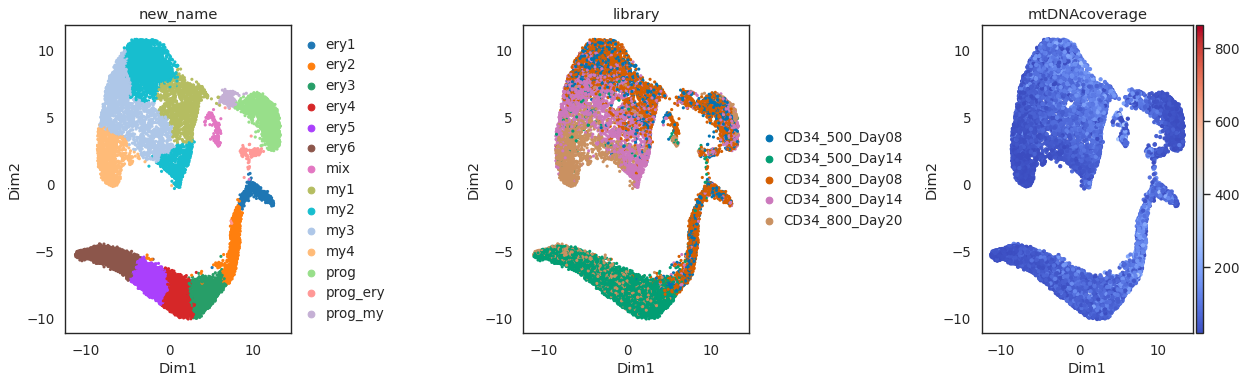

In [10]:
me.pl.scatter(adata, color=['new_name', 'library', 'mtDNAcoverage'], drawing_order='random')

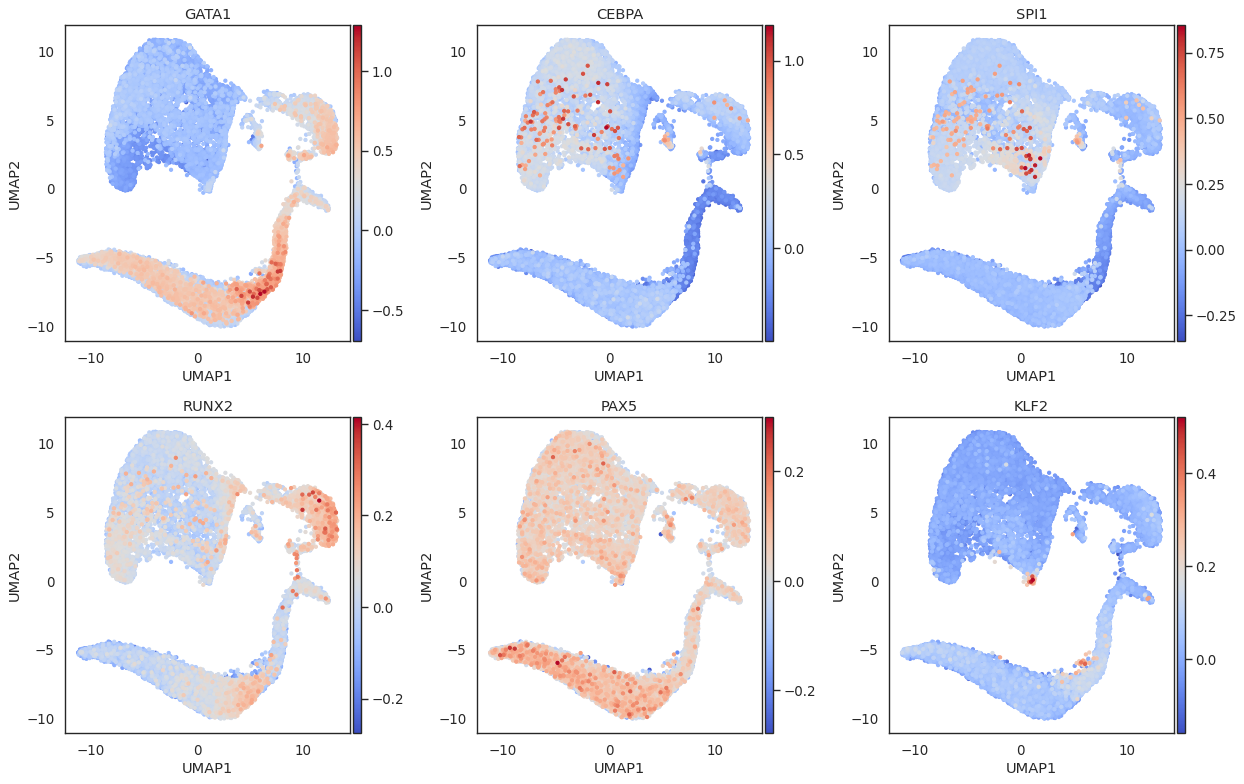

In [11]:
me.pl.umap(adata, color=['GATA1', 'CEBPA', 'SPI1', 'RUNX2', 'PAX5', 'KLF2'])

# Add clone annotations
Here we use the 197 clones called in the original paper, but we could use raw genotype calls

In [12]:
dummies = pd.get_dummies(data_df['clone_id'], sparse=True)
clone_mat = csr_matrix(dummies)
clone_mat.shape

(18259, 197)

In [13]:
me.pp.add_clones(adata,mat=clone_mat, anno=pd.DataFrame(index=dummies.columns))
me.pp.filter_clones(adata,min_cells=1)
adata.uns['clone']

Before filtering: 197 clones
After filtering: 197 clones


{'anno': Empty DataFrame
 Columns: []
 Index: [CD34_500_0, CD34_500_1, CD34_500_10, CD34_500_11, CD34_500_12, CD34_500_13, CD34_500_14, CD34_500_15, CD34_500_16, CD34_500_17, CD34_500_18, CD34_500_19, CD34_500_2, CD34_500_20, CD34_500_21, CD34_500_22, CD34_500_23, CD34_500_24, CD34_500_25, CD34_500_26, CD34_500_27, CD34_500_28, CD34_500_29, CD34_500_3, CD34_500_30, CD34_500_31, CD34_500_32, CD34_500_33, CD34_500_34, CD34_500_35, CD34_500_36, CD34_500_37, CD34_500_38, CD34_500_39, CD34_500_4, CD34_500_40, CD34_500_41, CD34_500_42, CD34_500_43, CD34_500_44, CD34_500_45, CD34_500_46, CD34_500_47, CD34_500_48, CD34_500_49, CD34_500_5, CD34_500_50, CD34_500_51, CD34_500_52, CD34_500_53, CD34_500_54, CD34_500_55, CD34_500_56, CD34_500_57, CD34_500_58, CD34_500_59, CD34_500_6, CD34_500_60, CD34_500_61, CD34_500_62, CD34_500_63, CD34_500_64, CD34_500_65, CD34_500_66, CD34_500_67, CD34_500_68, CD34_500_69, CD34_500_7, CD34_500_70, CD34_500_71, CD34_500_72, CD34_500_73, CD34_500_74, CD34_500_75,

In [14]:
adata.obs['time'] = adata.obs['library'].apply(lambda x: int(x[-2:]))

In [15]:
adata.obs['time']

CD34_500_Day08-AAACGAAAGACAGCTG-1     8
CD34_500_Day08-AAACGAACATAGATAG-1     8
CD34_500_Day08-AAACGAAGTACGTAGG-1     8
CD34_500_Day08-AAACGAAGTTATGCAC-1     8
CD34_500_Day08-AAACTCGCAACTTGGT-1     8
                                     ..
CD34_800_Day20-TTTGTGTGTAAACGGC-1    20
CD34_800_Day20-TTTGTGTGTGCACATT-1    20
CD34_800_Day20-TTTGTGTGTTAAGTCC-1    20
CD34_800_Day20-TTTGTGTGTTTGACCA-1    20
CD34_800_Day20-TTTGTGTTCGTCTTAT-1    20
Name: time, Length: 18259, dtype: int64

# Clustering clones into metaclones using MEGATRON
We choose 3 metaclones based on the original paper's observation that most clones are either monocyte-biased, erythroid-biased, or bipotent

In [16]:
%%time

me.tl.clone_distance(adata,
                     obsm='X_umap',
                     # anno_time='time',
                     anno_time=None,
                     # method='centroid',
                     method='geodesic',
                     n_jobs=8)

Finished: 0.27372958660125735 mins
CPU times: user 1min 27s, sys: 37.1 s, total: 2min 4s
Wall time: 16.4 s


In [17]:
me.tl.cluster_clones(adata,
                     n_clusters=3,
                     method='hierarchical')

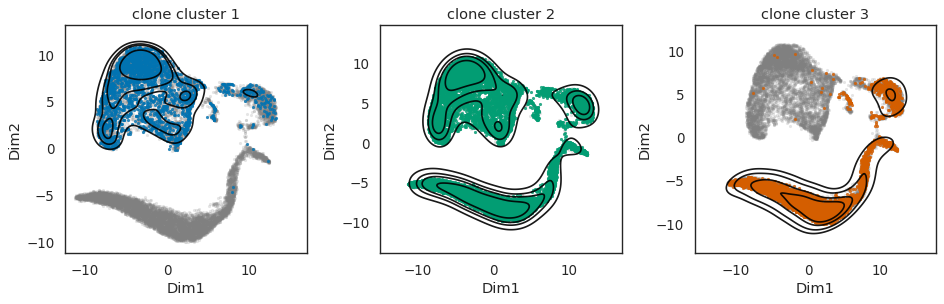

In [18]:
me.pl.clone_clusters(adata,
                    group='hierarchical',
                    obsm='X_umap',
                    show_contour=True, 
                    levels=5,
                    thresh=0.2)
plt.show()

In [ ]:
arr = adata.obsm['X_clone'] @ pd.get_dummies(adata.uns['clone']['anno']['hierarchical']).values
clust_labels = adata.uns['clone']['anno']['hierarchical']
# adata.obsm['X_clone'].sum(axis=0)[:,(clust_labels=='3')]

def n_largest_clones_in_metaclone(adata,metaclone,n=4):
    counts_by_clone = adata.obsm['X_clone'].sum(axis=0).A1 * (clust_labels==metaclone)
    return counts_by_clone.nlargest(n).index

max_clones={c:n_largest_clones_in_metaclone(adata, c) for c in ['1','2','3']}
max_clones
# max_clones = [(adata.obsm['X_clone'].sum(axis=0).A1 * (clust_labels==c)).argmax() for c in ['1','2','3']]
# max_clones

{'1': Index(['CD34_800_16', 'CD34_800_23', 'CD34_800_27', 'CD34_800_32'], dtype='object'),
 '2': Index(['CD34_500_0', 'CD34_800_0', 'CD34_800_1', 'CD34_500_2'], dtype='object'),
 '3': Index(['CD34_500_1', 'CD34_500_4', 'CD34_500_8', 'CD34_500_10'], dtype='object')}

CD34_800_16
CD34_800_23
CD34_800_27
CD34_800_32
CD34_500_0
CD34_800_0
CD34_800_1
CD34_500_2
CD34_500_1
CD34_500_4
CD34_500_8
CD34_500_10


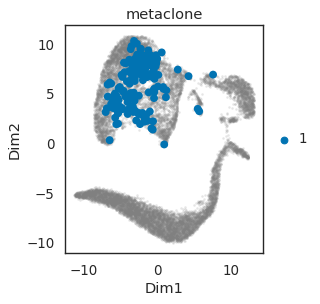

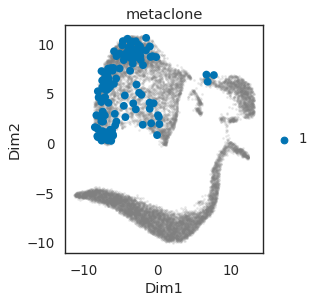

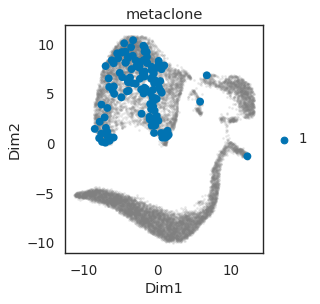

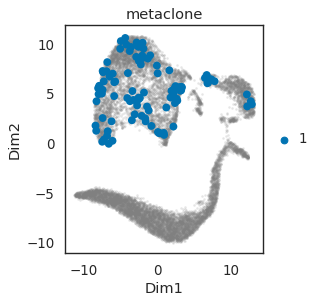

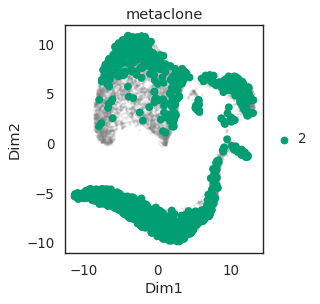

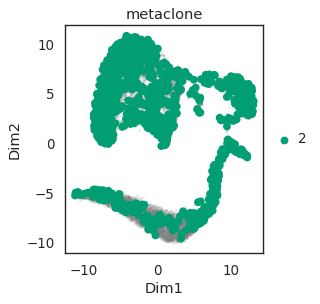

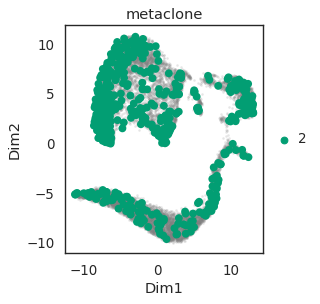

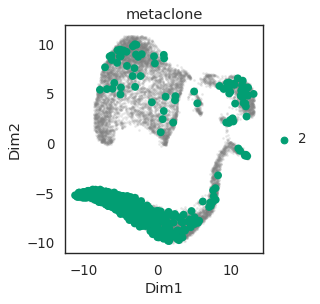

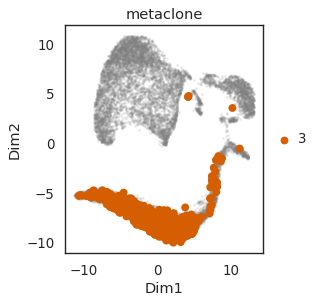

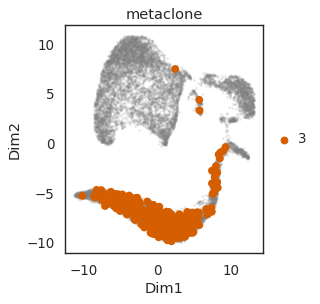

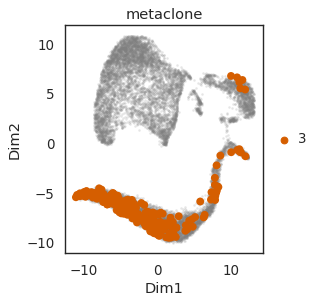

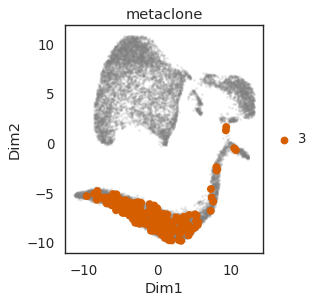

In [ ]:
with plt.rc_context({'figure.figsize':[4,4]}):
    for metaclone, top_clones in max_clones.items():
        for i in top_clones:
            print(i)
            me.pl.clones(adata, ids=i, obsm="X_umap", color=['metaclone'])

# Cluster-based analysis of metaclones
We compute a k-NN graph based on the UMAP embedding of cells. We could alternatively compute this graph based on another dimensionality-reduced projection of the data (e.g. PCA)

In [19]:
%autoreload
me.tl.build_graph(adata, obsm='X_umap', k=3, n_clusters=40)

Here is the k-NN graph with cluster labels, which we can use for downstream analysis

graph already built, using previous (set force=True to clobber)


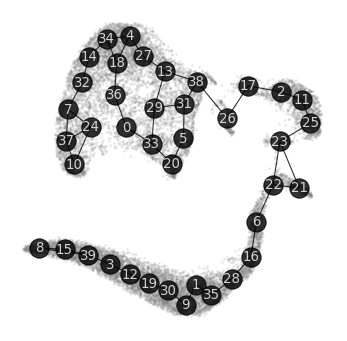

In [20]:
%autoreload
me.pl.cluster_graph(adata, obsm='X_umap', node_color="black", alpha=0.8)
plt.show()

And here is the same k-NN graph, except we replace the labeled nodes with pie charts whose size indicates number of cells and whose colors reflect the metaclone composition of cells belonging to each node/"meta-cell"

graph already built, using previous (set force=True to clobber)


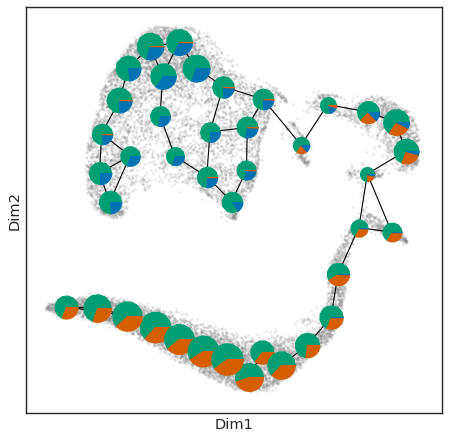

In [21]:
%autoreload

with plt.rc_context({'figure.figsize':[6,6]}):
    # plt.title(f"k={adata.uns['cluster_pos'].shape[0]}")
    me.pl.cluster_pie_graph(adata, obsm="X_umap")
    # plt.gca().set_aspect("equal")
    plt.show()
    # plt.savefig('scatterpie.png', transparent=True)


Node 11 is conveniently at the center of the progenitor cluster so we use it as the 'root' for the pseudotime analysis below

In [22]:
progenitor_clusters = [11]
me.tl.calculate_pseudotime(adata, progenitor_clusters)

## Graph-based pseudotime analysis by metaclone
We use the pseudotime analysis (or the original cluster labels) to restrict ourselves to an original population of cells which we believe are the early progenitor population. We then see if we can identify epigenetic differences in these early progenitors that foreshadow their downstream fates (as reflected by metaclone membership)

/PHShome/ljb80/ssd/logan/mambaforge/envs/logan_MEGATRON/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'new_name' as categorical
/PHShome/ljb80/ssd/logan/mambaforge/envs/logan_MEGATRON/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'library' as categorical


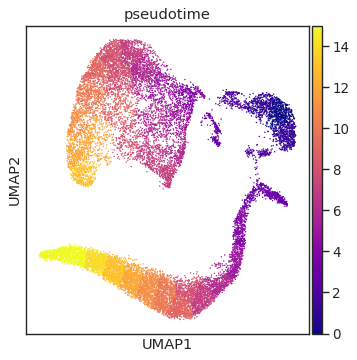

In [25]:
adata.obs['pseudotime']=adata.uns['cluster_pseudotime'].loc[adata.obs['cluster']].values
# adata.obs['pseudotime']=np.minimum(10,adata.obs['pseudotime'])
# adata.obs['pseudotime'] = (adata.obs['pseudotime']/adata.obs['pseudotime'].max()*n_pseudotime_bins).apply(np.ceil).astype(int)
sc.pl.umap(adata,color=['pseudotime'], cmap='plasma')

In [26]:
# progenitor_cells = adata[adata.obs['cluster'].isin(progenitor_clusters)& adata.obs['library'].str.contains('Day08')]
progenitor_cells = adata[(adata.obs['new_name']=='prog')& adata.obs['library'].str.contains('Day08')]

# progenitor_cells = adata[adata.obs['cluster'].isin(progenitor_clusters) & adata.obs['metaclone'].isin(['1','3'])& adata.obs['library'].str.contains('Day08')]
progenitor_cells.obs

,sample,depth,FRIP,mtDNAcoverage,new_name,library,time,cluster,metaclone,pseudotime
CD34_500_Day08-AAACGAACATAGATAG-1,AAACGAACATAGATAG-1,33704.0,0.526466,55.30,prog,CD34_500_Day08,8,2,2,1
CD34_500_Day08-AAACGAAGTTATGCAC-1,AAACGAAGTTATGCAC-1,34093.0,0.545215,31.51,prog,CD34_500_Day08,8,25,3,1
CD34_500_Day08-AAACTCGCATGGATGG-1,AAACTCGCATGGATGG-1,47756.0,0.482829,102.19,prog,CD34_500_Day08,8,11,1,0
CD34_500_Day08-AAACTGCAGTCTCGAT-1,AAACTGCAGTCTCGAT-1,35822.0,0.620596,37.83,prog,CD34_500_Day08,8,25,2,1
CD34_500_Day08-AAAGATGCATCGACCG-1,AAAGATGCATCGACCG-1,27962.0,0.611866,35.24,prog,CD34_500_Day08,8,25,2,1
...,...,...,...,...,...,...,...,...,...,...
CD34_800_Day08-TTTGTGTCAATGTAAG-1,TTTGTGTCAATGTAAG-1,17905.0,0.558838,28.06,prog,CD34_800_Day08,8,11,2,0
CD34_800_Day08-TTTGTGTCACACACCG-1,TTTGTGTCACACACCG-1,38074.0,0.468351,67.52,prog,CD34_800_Day08,8,2,2,1
CD34_800_Day08-TTTGTGTGTACTTCGA-1,TTTGTGTGTACTTCGA-1,31420.0,0.521260,45.21,prog,CD34_800_Day08,8,2,2,1
CD34_800_Day08-TTTGTGTTCCAAGTCA-1,TTTGTGTTCCAAGTCA-1,33036.0,0.627316,33.03,prog,CD34_800_Day08,8,2,3,1


In [27]:
progenitor_cells

View of AnnData object with n_obs × n_vars = 1073 × 870
    obs: 'sample', 'depth', 'FRIP', 'mtDNAcoverage', 'new_name', 'library', 'time', 'cluster', 'metaclone', 'pseudotime'
    var: 'fractionMatches', 'fractionBackgroundOverlap'
    uns: 'X_name', 'color', 'clone', 'cluster_pos', 'cluster_pdist', 'cluster_edgelist', 'cluster_pseudotime'
    obsm: 'X_umap', 'X_clone'
    layers: 'z', 'z_norm'

## Differential testing
Having identified a population of cells we want to test for metaclone-associated differences, we perform some simple statistical tests to identify significant differences

In [29]:
%autoreload

group1 = ['1'] # the first metaclone to test against
group2 = ['3'] # the second metaclone to test against

me.tl.differential_test_vars(progenitor_cells, group1, group2, test="t-test")
me.tl.differential_test_vars(progenitor_cells, group1, group2, test="wilcoxon")


Trying to set attribute `._uns` of view, copying.


In [30]:
progenitor_cells.uns['wilcoxon_MEGATRON']

,coef,p_value,gene,p_value_corr
154,0.033173,0.000824,CEBPA,0.162044
121,0.034431,0.000854,ATF4,0.162044
132,0.035746,0.000948,NFIL3,0.162044
55,0.009705,0.001044,TCF12,0.162044
617,0.016457,0.001175,POU3F1,0.162044
...,...,...,...,...
748,0.000004,0.996419,CIC,0.999105
59,-0.001047,0.998210,USF1,0.999105
301,0.003651,0.999105,TET1,0.999105
398,-0.002089,0.999105,HOXC8,0.999105


In [31]:
progenitor_cells.uns['t-test_MEGATRON']

,coef,p_value,gene,p_value_corr
121,0.034431,0.000181,ATF4,0.062688
132,0.035746,0.000188,NFIL3,0.062688
154,0.033173,0.000216,CEBPA,0.062688
109,0.044859,0.000590,DBP,0.102547
111,0.035991,0.000690,HLF,0.102547
...,...,...,...,...
291,0.000117,0.989986,CUX2,0.993877
660,-0.000049,0.990450,ESR1,0.993877
481,0.000056,0.993754,PDX1,0.996043
20,0.000019,0.997020,TCF3,0.998167


In [32]:
test_type='t-test_MEGATRON'

alpha = 0.1
test_df = progenitor_cells.uns[test_type].assign(
    significant=lambda x: x['p_value_corr']<alpha
)
signif_results = test_df.query('significant').sort_values('p_value')
signif_results

,coef,p_value,gene,p_value_corr,significant
121,0.034431,0.000181,ATF4,0.062688,True
132,0.035746,0.000188,NFIL3,0.062688,True
154,0.033173,0.000216,CEBPA,0.062688,True


In [33]:
signif_genes = signif_results['gene']

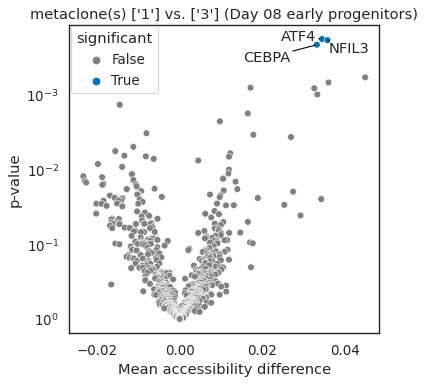

In [34]:
plt.yscale('log')
sns.scatterplot(x='coef',y='p_value',hue='significant', data=test_df,
                palette=["grey",clone_pal[0]])
    
texts = test_df[test_df['significant']].apply(
    lambda row: plt.text(row['coef'],row['p_value'], s=row['gene']), axis=1
)
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), va='center', autoalign='x')
    
plt.ylabel('p-value')
plt.xlabel('Mean accessibility difference')
plt.title(f'metaclone(s) {group1} vs. {group2} (Day 08 early progenitors)')

plt.gca().invert_yaxis()
plt.show()

In [35]:
adata.obs['library']

CD34_500_Day08-AAACGAAAGACAGCTG-1    CD34_500_Day08
CD34_500_Day08-AAACGAACATAGATAG-1    CD34_500_Day08
CD34_500_Day08-AAACGAAGTACGTAGG-1    CD34_500_Day08
CD34_500_Day08-AAACGAAGTTATGCAC-1    CD34_500_Day08
CD34_500_Day08-AAACTCGCAACTTGGT-1    CD34_500_Day08
                                          ...      
CD34_800_Day20-TTTGTGTGTAAACGGC-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTGTGCACATT-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTGTTAAGTCC-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTGTTTGACCA-1    CD34_800_Day20
CD34_800_Day20-TTTGTGTTCGTCTTAT-1    CD34_800_Day20
Name: library, Length: 18259, dtype: category
Categories (5, object): ['CD34_500_Day08', 'CD34_500_Day14', 'CD34_800_Day08', 'CD34_800_Day14', 'CD34_800_Day20']

day 8 progenitors only
all day 8 cells


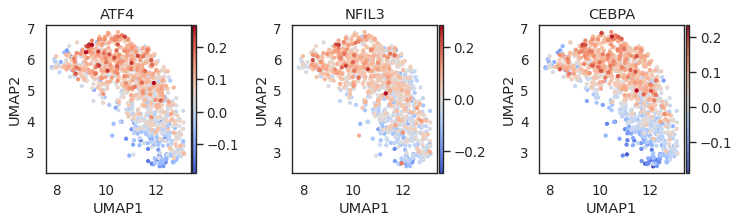

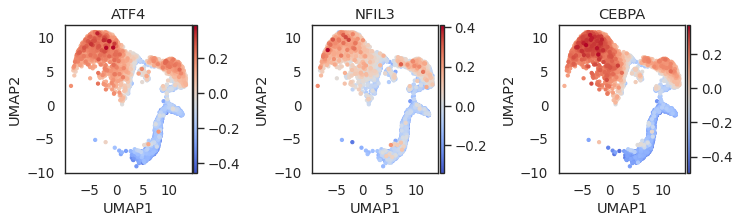

In [36]:
genes = list(signif_genes)
# genes = ['RUNX1','RUNX2','CBFB']
with plt.rc_context({'image.cmap': 'coolwarm',
                    'figure.figsize':[3,3]}):
    # me.pl.scatter(progenitor_cells, color=signif_genes)
    print("day 8 progenitors only")
    me.pl.umap(progenitor_cells, color=genes)
    print("all day 8 cells")
    me.pl.umap(adata[adata.obs['library'].str.contains('Day08')], color=genes)

    # me.pl.scatter(progenitor_cells[progenitor_cells.obs['metaclone']=='1'], color=['CEBPB','NFIL3','GATA1'])
    # me.pl.scatter(progenitor_cells[progenitor_cells.obs['metaclone']=='3'], color=['CEBPB','NFIL3','GATA1'])


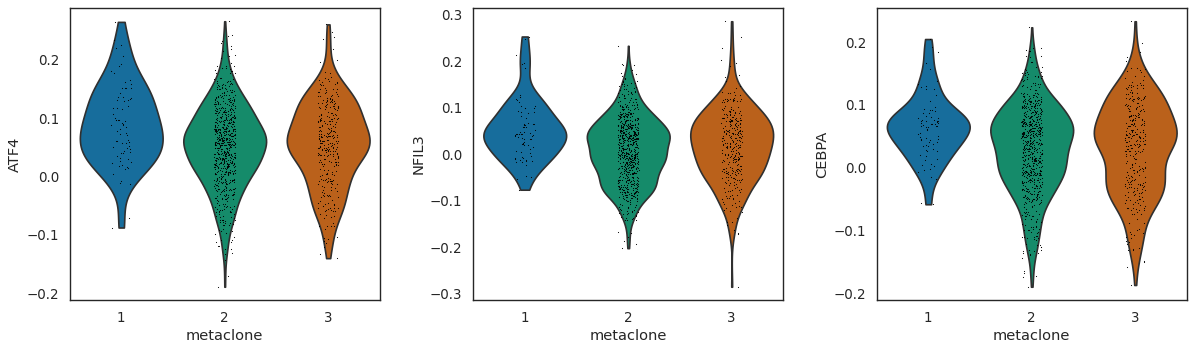

In [37]:
sc.pl.violin(progenitor_cells, genes, groupby="metaclone", palette=sns.color_palette())
# plt.title("Accessibility (early progenitors)")

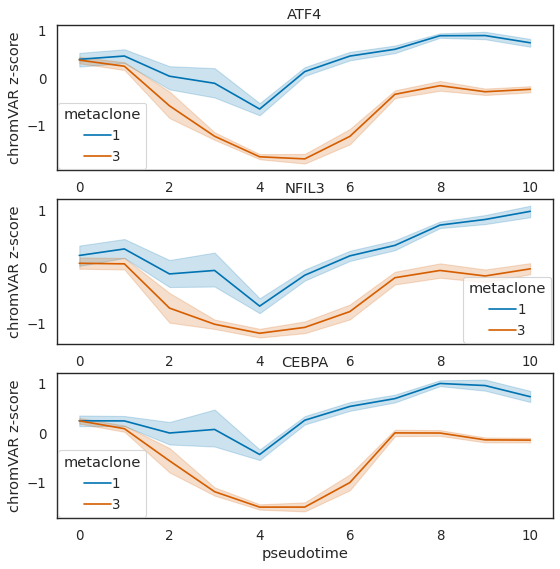

In [38]:
# sc.pl.scatter(adata,x='pseudotime',y='CEBPA', color="metaclone", layers='z_norm')
# for m in ['1','2','3']:
max_pseudotime=10
with plt.rc_context({'figure.figsize':[8,8]}):
    fig, axs=plt.subplots(3, )
top_genes = ['ATF4', 'NFIL3', 'CEBPA']
for ax, gene in zip (axs, top_genes):
        
    plot_adata = adata[(adata.obs['pseudotime']<=max_pseudotime) & (adata.obs['metaclone'].isin(group1+group2))]
    gene_value = plot_adata[:,gene].layers['z_norm'].copy().squeeze()
    # gene_value = plot_adata[:,gene].X.copy().squeeze()

    # print(plot_values.)
    ax.set_title(gene)
    ax.set_ylabel('chromVAR z-score')
    ax.set_xlabel('pseudotime')
    # sns.violinplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'])
    # sns.stripplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'], alpha=0.8, size=2)
    sns.lineplot(x=plot_adata.obs['pseudotime'],y=gene_value, hue=plot_adata.obs['metaclone'], palette=sns.color_palette()[0:3:2], ax=ax)
plt.show()
        